**Column Details:**
- **date**: The date on which the sales transaction occurred.
- **store**: The store identifier where the transaction took place.
- **item**: The item identifier for the product sold.
- **sales**: The number of units sold for the given item on the given date.


In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data
df = pd.read_csv(r'/content/inventory.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
parts = df['date'].str.split("-", n=3, expand=True)
df['year'] = parts[0].astype(int)
df['month'] = parts[1].astype(int)
df['day'] = parts[2].astype(int)
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [7]:
# Finding out if we have any
from datetime import datetime
import calendar

def weekend_or_weekday(year,month,day):

    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [8]:
# Adding a holiday column
from datetime import date
import holidays

def is_holiday(x):

    indian_holidays = holidays.country_holidays('IN')

    if indian_holidays.get(x):
        return 1
    else:
        return 0
df['holidays'] = df['date'].apply(is_holiday)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [9]:
# Adding some cylindrical features
df['m1'] = np.sin(df['month']*(2* np.pi/12))
df['m2'] = np.cos(df['month']*(2* np.pi/12))
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [10]:
# Let's add a column that indicates which day of the week it is
from datetime import datetime
def which_day(year, month, day):
    d = datetime(year, month, day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [11]:
# Let's remove the column which is of no use any more
df.drop('date', axis=1, inplace=True)

**EDA**

In [12]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

We have 10 stores and they'll sell 50 different items.

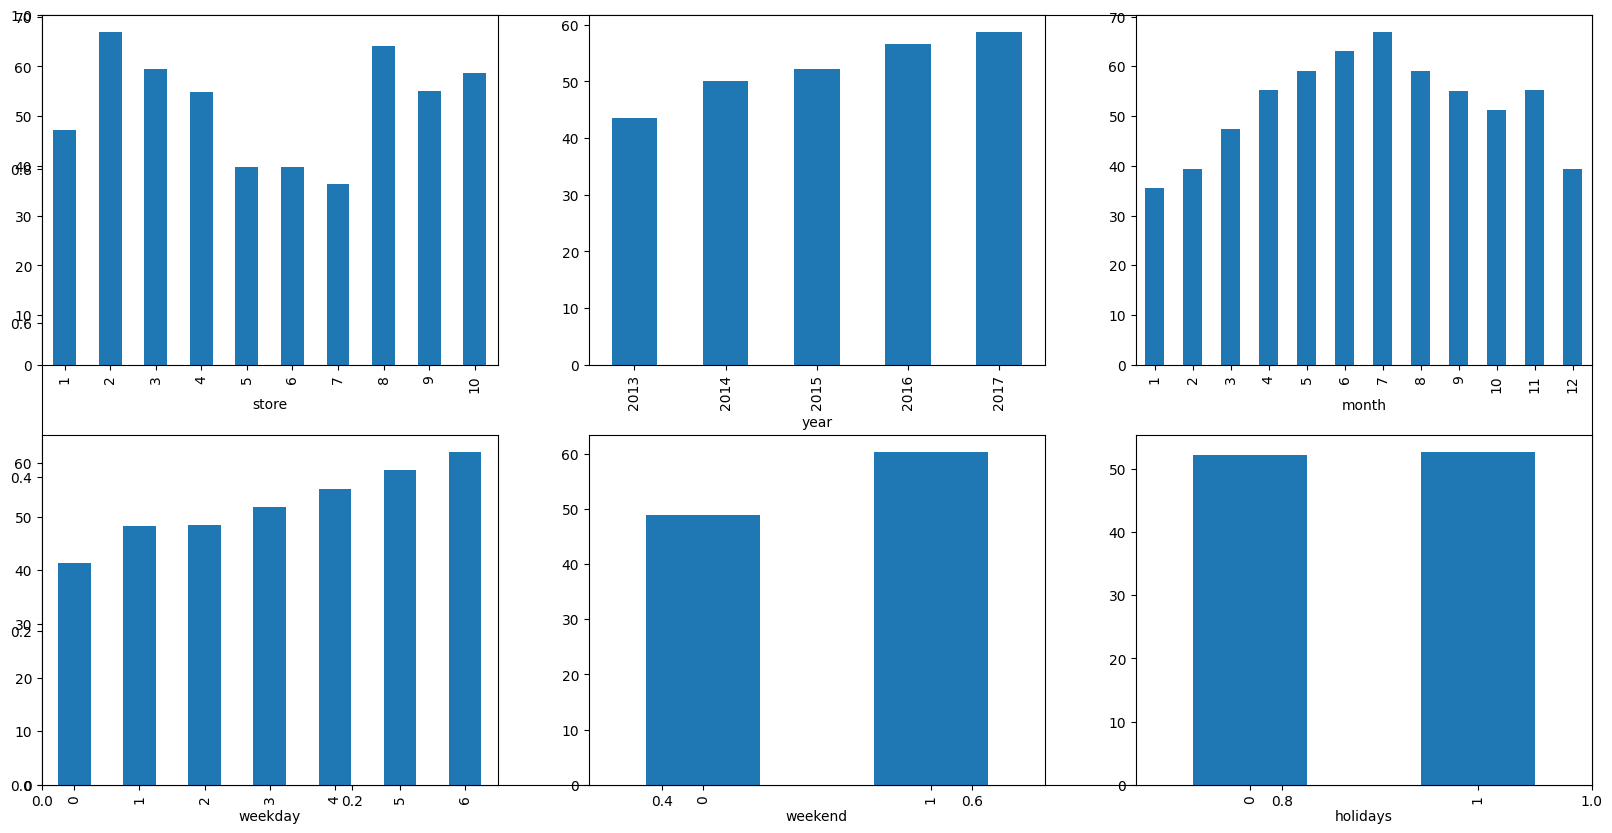

In [14]:
# Let's visualize the numerical columns
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
    plt.tight_layout()
plt.show()

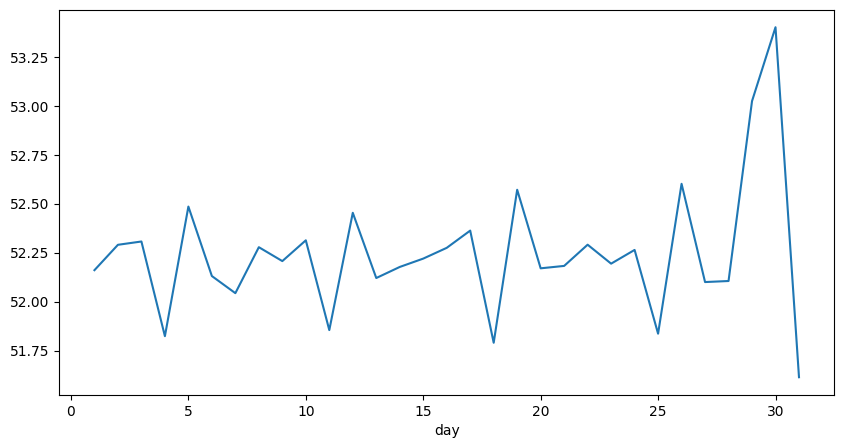

In [15]:
plt.figure(figsize=(10, 5))
df.groupby('day').mean()['sales'].plot()
plt.show()

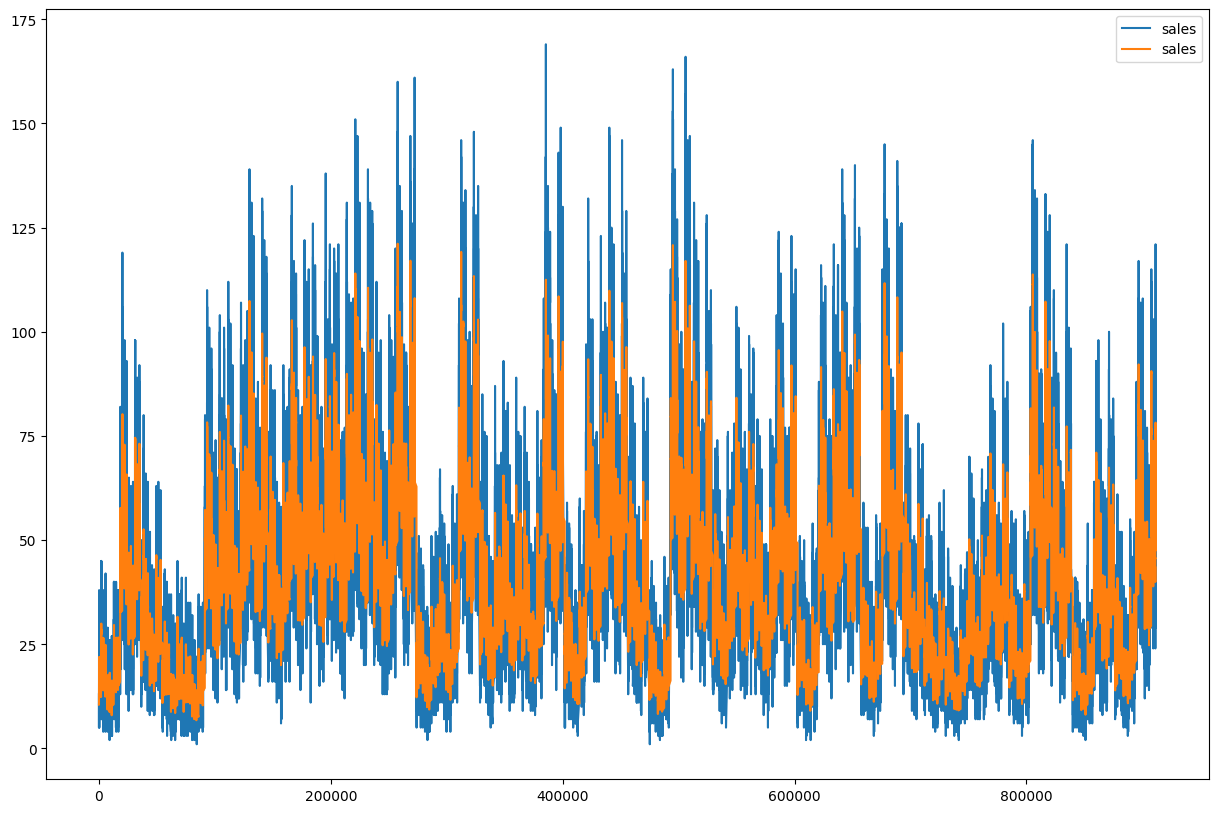

In [16]:
# Let's Draw a moving average of 30 days period
plt.figure(figsize=(15, 10))
window_size = 30
data = df[df['year'] == 2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size-1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

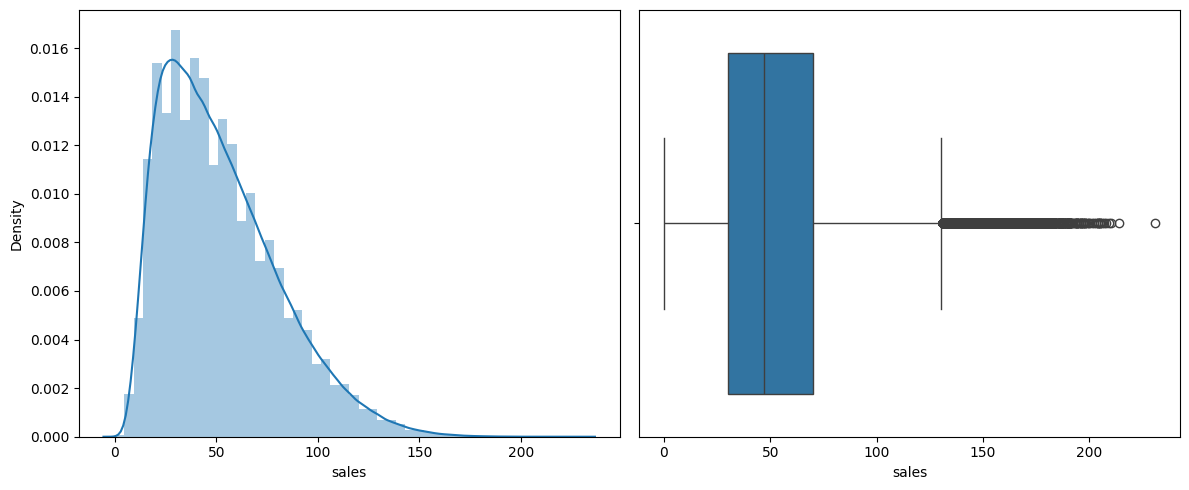

In [23]:
# Let's check the distribution of sales colum
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.distplot(df['sales'])

plt.subplot(1, 2, 2)
sns.boxplot(x=df['sales'])
plt.tight_layout()
plt.show()

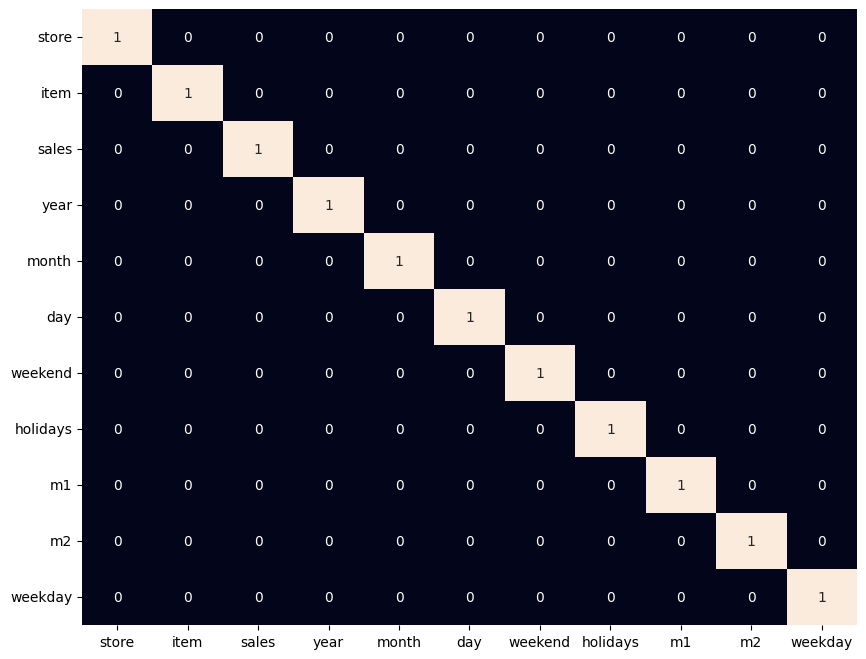

In [27]:
# Let's check for correlation among all the columns

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr()>0.8, annot=True, cbar=False)
plt.show()

In [28]:
# Let's remove outliers from the sales column
print(df.shape)
df = df[df['sales']<140]
print(df.shape)

(913000, 11)
(906495, 11)


**Model** **Training**

In [29]:
#Feature extraction
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.05, random_state=42)
x_train.shape, x_test.shape

((861170, 9), (45325, 9))

In [30]:
#Normalizing the dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [31]:
# Model building
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
    models[i].fit(x_train, y_train)
    print(models[i].__class__.__name__)

    train_pred = models[i].predict(x_train)
    print('Training Error: ', mae(train_pred, y_train))

    test_pred = models[i].predict(x_test)
    print('Testing Error: ', mae(test_pred, y_test))
    print()

LinearRegression
Training Error:  20.903803907041596
Testing Error:  20.942425174675652

XGBRegressor
Training Error:  6.966623783111572
Testing Error:  7.038644313812256

Lasso
Training Error:  21.016000846397453
Testing Error:  21.04847607513433

Ridge
Training Error:  20.903804043315173
Testing Error:  20.942425246005207



The performing model among all the four is XGBRegressor. It is a good model.

Thank you for going through my work till the end, Feel free to get in touch if you have questions... :)